# Stock price predictions

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams

from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense
from sklearn.preprocessing import MinMaxScaler
import warnings

2023-07-08 17:37:09.047993: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Preprocessing

In [2]:
nse=pd.read_csv('NSE-Tata-Global-Beverages-Limited.csv')
nse.isnull().any()

Date                    False
Open                    False
High                    False
Low                     False
Last                    False
Close                   False
Total Trade Quantity    False
Turnover (Lacs)         False
dtype: bool

There appears to be no missing values contained in this time series based data set so no imputation is required. This is ideal because forecasting will operate smoothly.

In [3]:
nse['Date']=pd.to_datetime(nse.Date,format='%Y-%m-%d')
nse.index=nse['Date']

In [4]:
nse.head()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
Date,,,,,,,,
2018-10-08,2018-10-08,208.00,222.25,206.85,216.00,215.15,4642146.0,10062.83
2018-10-05,2018-10-05,217.00,218.60,205.90,210.25,209.20,3519515.0,7407.06
2018-10-04,2018-10-04,223.50,227.80,216.15,217.25,218.20,1728786.0,3815.79
2018-10-03,2018-10-03,230.00,237.50,225.75,226.45,227.60,1708590.0,3960.27
2018-10-01,2018-10-01,234.55,234.60,221.05,230.30,230.90,1534749.0,3486.05


## EDA and Visualisation

In [5]:
data=nse.sort_index(ascending=True,axis=0)
new_dataset=pd.DataFrame(index=range(0,len(nse)),columns=['Date','Close'])

for i in range(0,len(data)):
    new_dataset["Date"][i]=data['Date'][i]
    new_dataset["Close"][i]=data["Close"][i]

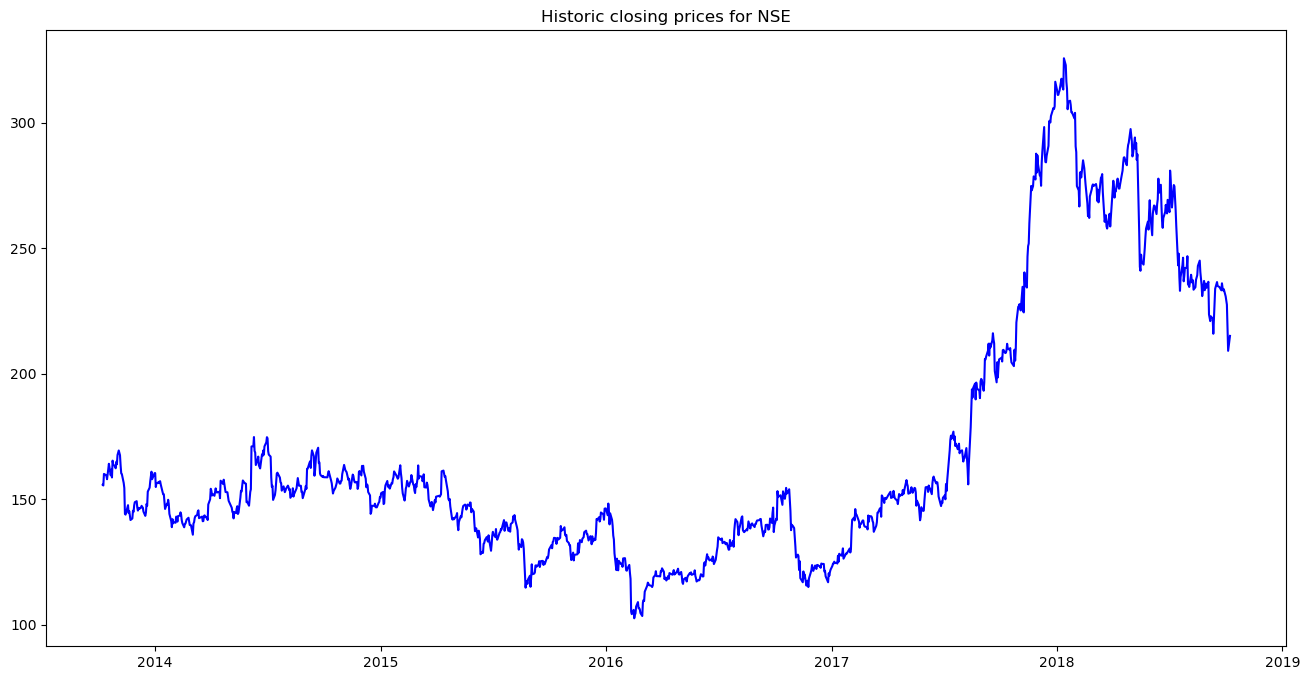

In [6]:
plt.figure(figsize=(16,8))
plt.plot(nse["Close"],label='Close Price History',c='b')
plt.title('Historic closing prices for NSE')
plt.show()

To detect anomalies, a rolling means graph has been provided. Rolling means operates by smoothing out time series data over a fixed period. For example, a rolling means graph can be used to compare performance on an annual basis and detect anomalies for each year.

In [7]:
#create separate datasets for each year
new_nse=new_dataset
new_nse['Date']=pd.to_datetime(new_nse.Date,format='%Y-%m-%d')
new_nse.index=new_nse['Date']
past_years=dict()
for i in range(13,18):
    past_years["fin{0}".format(i)]=new_nse['20{0}-10-08'.format(i):'20{0}-10-08'.format(i+1)]
    past_years["fin{0}".format(i)].drop('Date',axis=1,inplace=True)

/var/folders/xq/pbtny36j0pl28vpcjxxht3_00000gn/T/ipykernel_4145/962619695.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  past_years["fin{0}".format(i)].drop('Date',axis=1,inplace=True)
/var/folders/xq/pbtny36j0pl28vpcjxxht3_00000gn/T/ipykernel_4145/962619695.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  past_years["fin{0}".format(i)].drop('Date',axis=1,inplace=True)
/var/folders/xq/pbtny36j0pl28vpcjxxht3_00000gn/T/ipykernel_4145/962619695.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

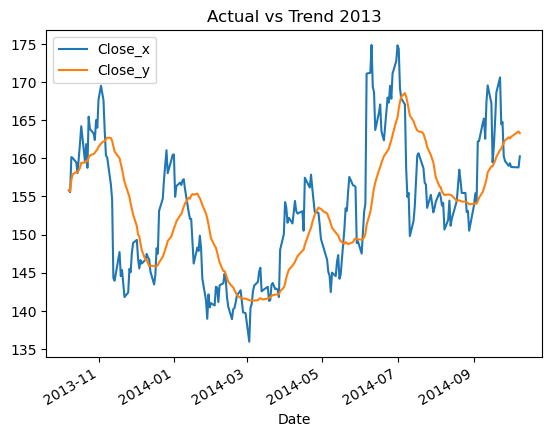

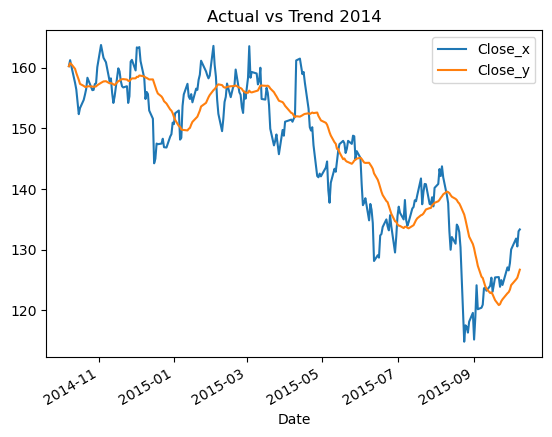

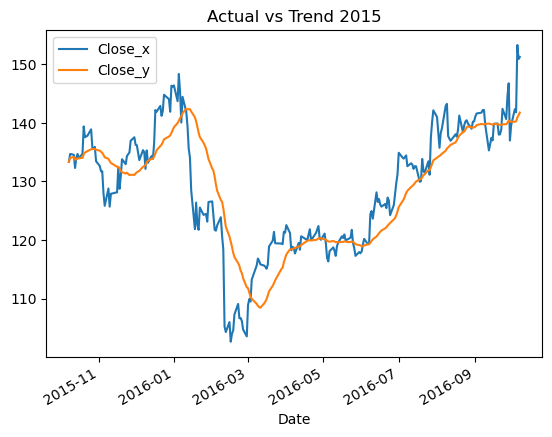

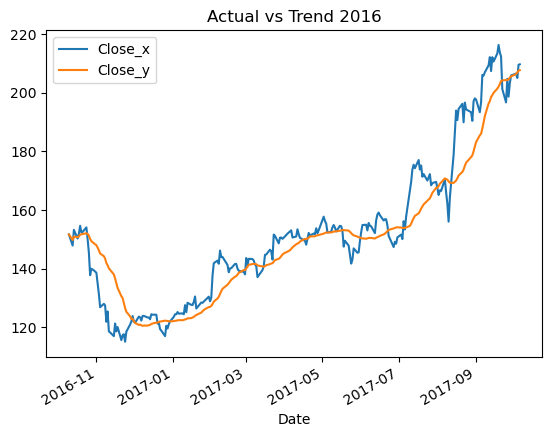

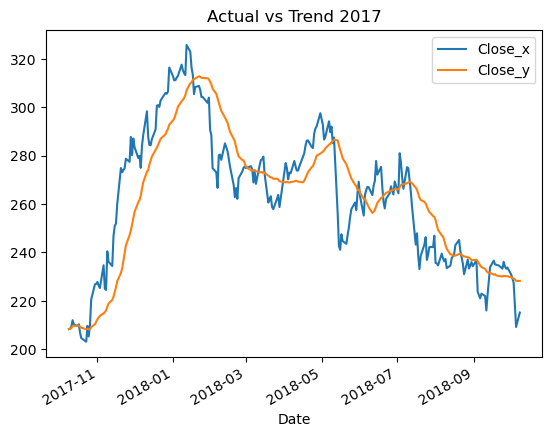

In [8]:
plot_data=dict()
for i in range(13,18):
    year=past_years['fin{0}'.format(i)]
    rolling_means=year.rolling('30D').mean()
    compared=year.merge(right=rolling_means,on='Date',how='right')
    plot_data['20{0}'.format(i)]=compared
    plot_data['20{0}'.format(i)].plot(title='Actual vs Trend 20{0}'.format(i))
    plt.legend()

No outstanding anomalies occur during the period of training. This is ideal for our model.

## Normalisation

In [9]:
scaler=MinMaxScaler(feature_range=(0,1))
final_dataset=new_dataset.values

train_data=final_dataset[0:987,:]
valid_data=final_dataset[987:,:]

new_dataset.index=new_dataset.Date
new_dataset.drop("Date",axis=1,inplace=True)

In [10]:
scaler=MinMaxScaler(feature_range=(0,1))
scaled_data=scaler.fit_transform(new_dataset)
x_train_data,y_train_data=[],[]
for i in range(60,len(train_data)):
    x_train_data.append(scaled_data[i-60:i,0])
    y_train_data.append(scaled_data[i,0])
    
x_train_data,y_train_data=np.array(x_train_data),np.array(y_train_data)
x_train_data=np.reshape(x_train_data,(x_train_data.shape[0],x_train_data.shape[1],1))

## Predictive Modelling

In [23]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
svr=SVR()
grid_space={'kernel':['rbf','poly','linear'],
            'C':[0.1,1,10,100],
            'gamma': [0.01,0.1,1]}
grid = GridSearchCV(estimator=svr,param_grid=grid_space,cv=3,scoring='accuracy')
X_train,y_train=[],[]
for i in range(60,len(train_data)):
    X_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])
grid = GridSearchCV(estimator=svr,param_grid=grid_space,cv=3,scoring='accuracy')
model_grid = grid.fit(X_train,y_train)
print('Best hyperparameters are: '+str(model_grid.best_params_))

/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 104, in _check_targets
    raise

Best hyperparameters are: {'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}


/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 211, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 104, in _check_targets
    raise

In [ ]:
lstm_model=Sequential()
lstm_model.add(LSTM(units=50,return_sequences=True,input_shape=(x_train_data.shape[1],1)))
lstm_model.add(LSTM(units=50))
lstm_model.add(Dense(1))

In [ ]:
inputs_data=new_dataset[len(new_dataset)-len(valid_data)-60:].values
inputs_data=inputs_data.reshape(-1,1)
inputs_data=scaler.transform(inputs_data)
lstm_model.compile(loss='mean_squared_error',optimizer='adam')
lstm_model.fit(x_train_data,y_train_data,epochs=1,batch_size=1,verbose=2)

In [ ]:
X_test=[]
for i in range(60,inputs_data.shape[0]):
    X_test.append(inputs_data[i-60:i,0])
X_test=np.array(X_test)

X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
predicted_closing_price=lstm_model.predict(X_test)
predicted_closing_price=scaler.inverse_transform(predicted_closing_price)

In [ ]:
train_data=new_dataset[:987]
valid_data=new_dataset[987:]
valid_data['Predictions']=predicted_closing_price
plt.plot(train_data["Close"])
plt.plot(valid_data[['Close',"Predictions"]])
plt.title('forecasted closing prices')